In [1]:
import reproducibility

setting TF_DETERMINISTIC_OPS=1 PYTHONHASHSEED=0
resetting random seed do 123
call set_seed() or set_seed(seed=value) to reset


In [2]:
# both can change
# Environment
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.utils.vis_utils import plot_model
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
from utils import hash2

# Local modules for handling data and running moisture models
import data_funcs as datf
from data_funcs import format_raws, retrieve_raws, format_precip, fixnan
from data_funcs import raws_data, synthetic_data, plot_data, check_data, mse_data, to_json, from_json
import moisture_models as mod
from moisture_rnn import create_RNN, create_RNN_2, staircase, seq2batches, create_rnn_data, train_rnn, rnn_predict

meso_token="b40cb52cbdef43ef81329b84e8fd874f"


In [3]:
# Change directory for data read/write
import os
os.chdir('data')

## Retrieve RAWS Data

In [4]:
# raws_dat=raws_data(start='201806010800', hours=1200, h2=300, stid="BKCU1",meso_token=meso_token)
raws_dat=from_json('kf_orig.json')
# hash2(raws_dat)

reading  kf_orig.json
filename = kf_orig.json   <class 'str'>
title = BKCU1 Kalman filtering and forecast with augmented state, real data. Training 0:300 hmax   <class 'str'>
note = RAWS and RTMA data + m from augmented KF in fmda_kf_rnn_orig   <class 'str'>
hours = 1200   <class 'int'>
h2 = 300   <class 'int'>
E not present
array Ed drying equilibrium (%) length 9218 min 1.6557478175353315 max 34.79658303880805 <class 'numpy.ndarray'>
array Ew wetting equilibrium (%) length 9218 min 1.0385669966012008 max 32.57269821483259 <class 'numpy.ndarray'>
array Ec equilibrium equilibrium (%) length 1200 min -2.0021484495502215 max 0.04713980095609851 <class 'numpy.ndarray'>
array rain rain intensity (mm/h) length 9218 min 0.0 max 14.62321996428548 <class 'numpy.ndarray'>
array fm RAWS fuel moisture data (%) length 9905 min 1.6 max 27.2 <class 'numpy.ndarray'>
array m fuel moisture estimate (%) length 1200 min 0.1 max 19.636011880151102 <class 'numpy.ndarray'>
Hash:  709909898222239762


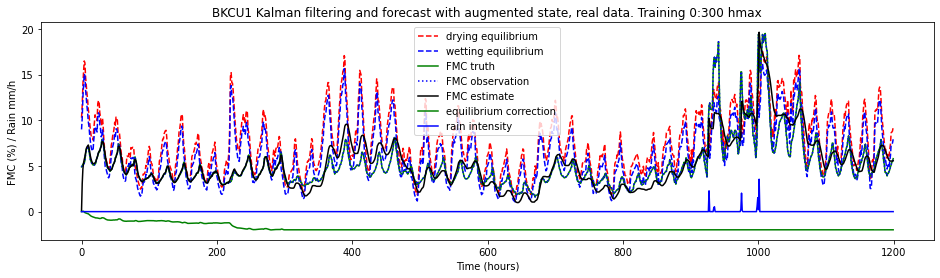

In [5]:
%matplotlib inline
plot_data(raws_dat)

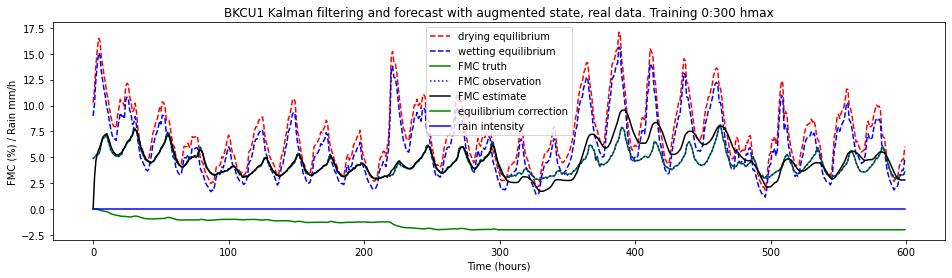

In [6]:
plot_data(raws_dat,hmax=600)

In [7]:
raws_dat.keys()

dict_keys(['title', 'hours', 'h2', 'Ed', 'Ew', 'Ec', 'rain', 'fm', 'm', 'note', 'filename'])

In [8]:
print('fm hash:', hash2(raws_dat['fm']))
print('rain hash:', hash2(raws_dat['rain']))
print('Ed hash:', hash2(raws_dat['Ed']))
print('Ew hash:', hash2(raws_dat['Ew']))
print('m hash:', hash2(raws_dat['m']))

fm hash: 4862104741624668658
rain hash: 2359448488008698515
Ed hash: 13930473820642652989
Ew hash: 7670338008735920320
m hash: 8250757611716755667


## Retrieve RTMA Function

<mark>Not needed?</mark>

## Interface
Jonathon changes above  create each case as a dictionary, then dictionary of dictionaries, figure out how to store and load dictionaries as a file. json is possible but: cannot contain datetime objects
look into pickle also compresses while json is plain text clone wrfxpy look how for idioms, pickle added jan/angel lager
Jan will edit from here below. 
cases will be extracted from dictionary as global variables for now at least

In [9]:
np.random.seed(seed=123)

In [10]:
# dictionary raws_dat has all that is needed for the run 
# keeping the name raws_dat for now even if it may not be raws data



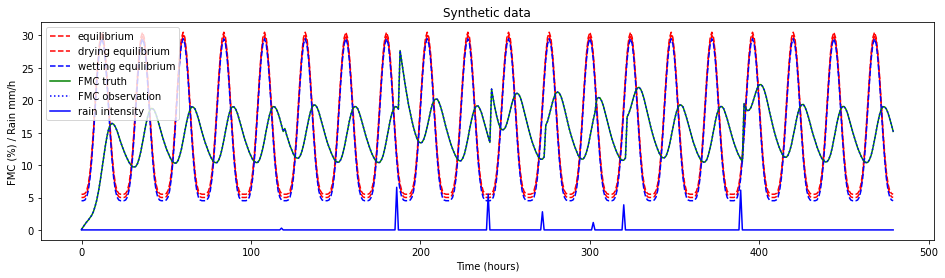

In [11]:
synt_dat=synthetic_data()  # just testinh
%matplotlib inline
plot_data(synt_dat)

## Fit Augmented KF

In [12]:
raws_dat.keys()

dict_keys(['title', 'hours', 'h2', 'Ed', 'Ew', 'Ec', 'rain', 'fm', 'm', 'note', 'filename'])

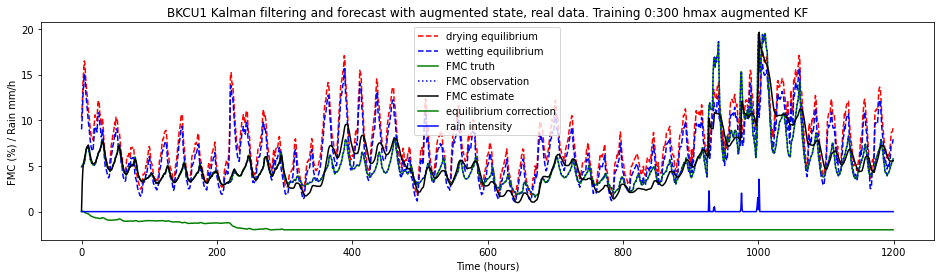

In [13]:
m,Ec = mod.run_augmented_kf(raws_dat)  # extract from state
raws_dat['m']=m
raws_dat['Ec']=Ec
plot_data(raws_dat,title2='augmented KF')

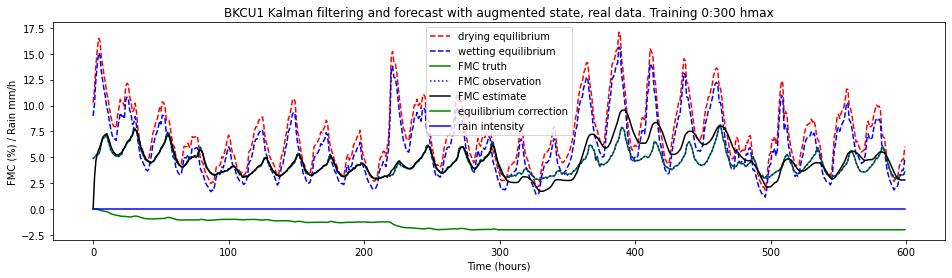

In [14]:
plot_data(raws_dat,hmin=0,hmax=600)

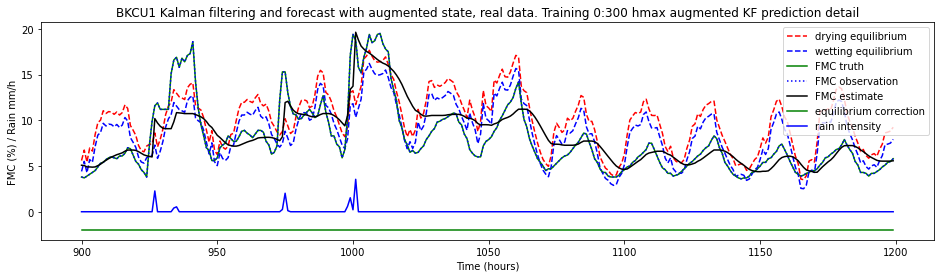

In [15]:
plot_data(raws_dat,hmin=900,hmax=1200,title2='augmented KF prediction detail')

In [16]:
mse_data(raws_dat)


Training MSE:   0.1092
Prediction MSE: 2.3417


## Fit RNN Model

In [17]:
# Set seed for reproducibility
tf.random.set_seed(123)

In [18]:
import pickle
# case_data = from_json('rnn_orig.json')
with open('testing_dict.pickle', 'rb') as handle:
    test_dict = pickle.load(handle)
case_data = test_dict['case11']

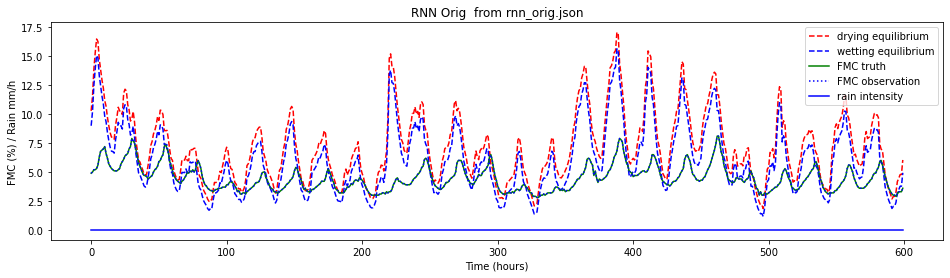

In [19]:
plot_data(case_data,title2=' from rnn_orig.json',hmin=0,hmax=600)

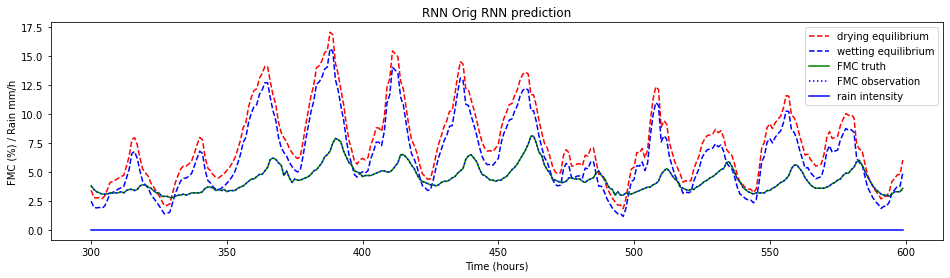

In [20]:
plot_data(case_data,title2='RNN prediction',hmin=300,hmax=600)

In [21]:
if 'm' in case_data:
    mse_data(case_data)  # just check sdolution if there
    del case_data['m']   # cleanup - remove old solution if any

In [22]:
verbose = False
# Set seed for reproducibility
tf.random.set_seed(123)
rnn_dat = create_rnn_data(case_data,scale=False, verbose=verbose)

In [23]:
## Check 1: equilibrium input data the same

print(hash2(rnn_dat['Et']))
print(hash2(rnn_dat['x_train']))
print(hash2(rnn_dat['y_train']))

6234897689711719103
8126391800620253839
10119650379183749962


In [24]:
model_predict = train_rnn(
    rnn_dat,
    rnn_dat['hours'],
    activation=['linear','linear'],
    hidden_units=6,
    dense_units=1,
    dense_layers=1,
    verbose = verbose
)

Function: moisture_rnn.create_RNN_2
Arguments:
  hidden_units = 6
  dense_units = 1
  activation = ['linear', 'linear']
  stateful = True
  batch_shape = (296, 5, 1)
  input_shape = None
  dense_layers = 1
  rnn_layers = 1
  return_sequences = False
  initial_state = None
  verbose = True
Function: moisture_rnn.create_RNN_2
Arguments:
  hidden_units = 6
  dense_units = 1
  activation = ['linear', 'linear']
  stateful = False
  batch_shape = None
  input_shape = (854, 1)
  dense_layers = 1
  rnn_layers = 1
  return_sequences = True
  initial_state = None
  verbose = True


In [25]:
m = rnn_predict(model_predict, rnn_dat, rnn_dat['hours'], verbose = verbose)
case_data['m'] = m
note = 'm replaced by a solution from fmda_rnn_rain'
if 'note' in case_data:
    case_data['note'] = case_data['note'] + '\n' + note
else:
    case_data['note'] = note
check_data(case_data)

filename not present
title = RNN Orig   <class 'str'>
note = m replaced by a solution from fmda_rnn_rain   <class 'str'>
hours = 854   <class 'int'>
h2 = 300   <class 'int'>
E not present
array Ed drying equilibrium (%) length 854 min 1.6557478175353315 max 17.076346687085564 <class 'numpy.ndarray'>
array Ew wetting equilibrium (%) length 854 min 1.0385669966012008 max 15.646159240682982 <class 'numpy.ndarray'>
Ec not present
array rain rain intensity (mm/h) length 854 min 0.0 max 0.0 <class 'numpy.ndarray'>
array fm RAWS fuel moisture data (%) length 854 min 1.6 max 8.1 <class 'numpy.ndarray'>
array m fuel moisture estimate (%) length 854 min 1.6078377 max 7.6357093 <class 'numpy.ndarray'>


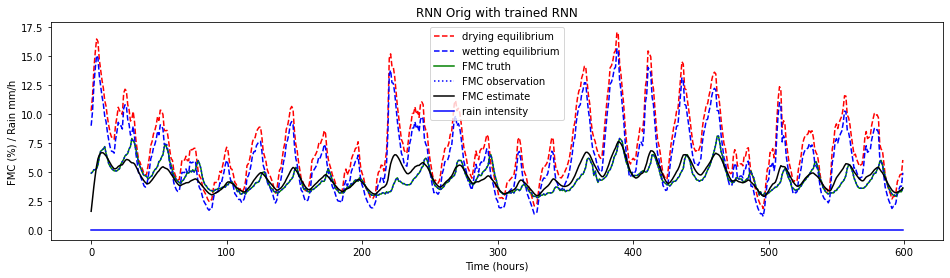

In [26]:
plot_data(case_data,title2='with trained RNN',hmin=0,hmax=600)


In [27]:
mse_data(case_data)

Training MSE:   0.5612
Prediction MSE: 0.4428


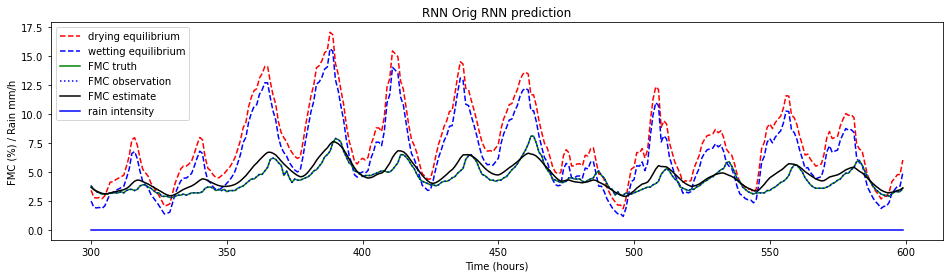

In [28]:
plot_data(case_data,title2='RNN prediction',hmin=300,hmax=600)

In [29]:
print(hash2(case_data['m']))

18388896644905057161


---
---

<mark>Start Here after Check 1<\mark>

In [ ]:
from utils import hash2

In [ ]:
#tf.keras.utils.set_random_seed(123)
#tf.random.set_seed(123)
reproducibility.set_seed()

In [ ]:
from utils import vprint

hours = rnn_dat['hours']
    
samples = rnn_dat['samples']
features = rnn_dat['features']
timesteps = rnn_dat['timesteps']
    
model_fit=create_RNN_2(hidden_units=6, 
                        dense_units=1, 
                        batch_shape=(samples,timesteps,features),
                        stateful=True,
                        return_sequences=False,
                        # initial_state=h0,
                        activation=['linear','linear'],
                        dense_layers=1)

from keras.utils.vis_utils import plot_model
plot_model(model_fit, to_file='model_plot.png', 
           show_shapes=True, show_layer_names=True)

In [ ]:
## Check 2: Untrained RNN initialized with same weights

hash2(model_fit.get_weights())

In [ ]:
Et = rnn_dat['Et']
model_predict=create_RNN_2(hidden_units=6, dense_units=1,  
                            input_shape=(hours,features),stateful = False,
                            return_sequences=True,
                            activation=['linear','linear'],dense_layers=1)

In [ ]:
## Check 3: Second model initialization same weights

hash2(model_predict.get_weights())

In [ ]:
print(rnn_dat)
x_train = rnn_dat['x_train']
y_train = rnn_dat['y_train']
type(x_train)

# print dimensions and set initial state
# print('model_fit input shape',x_train.shape,'output shape',model_fit(x_train).shape)

# fitting
DeltaE = 0
w_exact=  [np.array([[1.-np.exp(-0.1)]]), np.array([[np.exp(-0.1)]]), np.array([0.]),np.array([[1.0]]),np.array([-1.*DeltaE])]
    
w_initial=[np.array([[1.-np.exp(-0.1)]]), 
           np.array([[np.exp(-0.1)]]), 
           np.array([0.]),
           np.array([[1.0]]),
           np.array([-1.0])]
r = 1e-2
print('randomization of initial weights ',r)
w=model_fit.get_weights()
for i in range(len(w)):
    vprint('weight',i,'shape',w[i].shape,'ndim',w[i].ndim,'given',w_initial[i].shape)
    for j in range(w[i].shape[0]):
        if w[i].ndim==2:
            for k in range(w[i].shape[1]):
                w[i][j][k]=w_initial[i][0][0]/w[i].shape[0] + np.random.normal(0,1)*r
        else:
            w[i][j]=w_initial[i][0] + np.random.normal(0,1)*r
model_fit.set_weights(w)

In [ ]:
## Check 4: weights and inputs the same after this step 

print(hash2(model_fit.get_weights()))
print(hash2(x_train))
print(hash2(y_train))

In [ ]:
print('model_fit input shape',x_train.shape,'output shape',y_train.shape)
print('x_train',x_train)
print('y_train',y_train)

In [ ]:
reproducibility.set_seed()

In [ ]:
model_fit.get_weights()

In [ ]:
model_fit.fit(x_train, y_train, epochs=5000, verbose=2, batch_size=samples)
w_fitted=model_fit.get_weights()
for i in range(len(w)):
    vprint('weight',i,' exact:',w_exact[i],':  initial:',w_initial[i],' fitted:',w_fitted[i])
    
model_predict.set_weights(w_fitted)

In [ ]:
## Check 5: Weights NOT the same after fitting

hash2(model_fit.get_weights())

In [ ]:
model_fit.get_weights()

In [ ]:
model_fit.get_config()

In [ ]:
## RNN weights repeated in odd way that looks like untrained

model_fit.get_weights()

In [ ]:
# evaluate model
model_predict.set_weights(w_fitted)
x_input=np.reshape(Et,(1, hours, 2))
y_output = model_predict.predict(x_input)
print('x_input.shape=',x_input.shape,'y_output.shape=',y_output.shape)
# print(shift)
m = np.reshape(y_output,hours)
fitted_data = case_data.copy()
fitted_data.update({'m':m,'title':"First RNN forecast"})